In [0]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/
!kaggle competitions download -c severstal-steel-defect-detection

In [0]:
!unzip /content/Seversteel/test_images.zip -d /content/Seversteel/test_images
!unzip /content/Seversteel/train_images.zip -d /content/Seversteel/train_images 

In [0]:
!unzip -q /content/pretrainedmodels-0.7.4.zip

In [0]:
# What this is doing? please refer to my above linked kernel
!pip install /content/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4/ > /dev/null
package_path = '/content/unetmodelscript'
import sys
sys.path.append(package_path)

In [0]:
import pdb
import os
import cv2
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset
from albumentations import (Normalize, Compose)
from albumentations.torch import ToTensor
import torch.utils.data as data
from model import Unet

In [0]:
#https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [0]:
class TestDataset(Dataset):
    '''Dataset for test prediction'''
    def __init__(self, root, df, mean, std):
        self.root = root
        df['ImageId'] = df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
        self.fnames = df['ImageId'].unique().tolist()
        self.num_samples = len(self.fnames)
        self.transform = Compose(
            [
                Normalize(mean=mean, std=std, p=1),
                ToTensor(),
            ]
        )

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        path = os.path.join(self.root, fname)
        image = cv2.imread(path)
        images = self.transform(image=image)["image"]
        return fname, images

    def __len__(self):
        return self.num_samples

In [0]:
def post_process(probability, threshold, min_size):
    '''Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored'''
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((256, 1600), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [32]:
!ls /content/unet-starter-model-file/

model.pth


In [0]:
sample_submission_path = '/content/Seversteel/sample_submission.csv'
test_data_folder = "/content/Seversteel/test_images"

In [34]:
# initialize test dataloader
best_threshold = 0.5
num_workers = 2
batch_size = 4
print('best_threshold', best_threshold)
min_size = 3500
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
df = pd.read_csv(sample_submission_path)
testset = DataLoader(
    TestDataset(test_data_folder, df, mean, std),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

best_threshold 0.5


In [35]:
# Initialize mode and load trained weights
ckpt_path = "/content/unet-starter-model-file/model.pth"
device = torch.device("cuda")
model = Unet("resnet18", encoder_weights=None, classes=4, activation=None)
model.to(device)
model.eval()
state = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])

<All keys matched successfully>

In [36]:
# start prediction
predictions = []
for i, batch in enumerate(tqdm(testset)):
    fnames, images = batch
    batch_preds = torch.sigmoid(model(images.to(device)))
    batch_preds = batch_preds.detach().cpu().numpy()
    for fname, preds in zip(fnames, batch_preds):
        for cls, pred in enumerate(preds):
            pred, num = post_process(pred, best_threshold, min_size)
            rle = mask2rle(pred)
            name = fname + f"_{cls+1}"
            predictions.append([name, rle])

# save predictions to submission.csv
df = pd.DataFrame(predictions, columns=['ImageId_ClassId', 'EncodedPixels'])
df.to_csv("submission.csv", index=False)

100%|██████████| 451/451 [02:42<00:00,  2.78it/s]


In [133]:
df.head(5)

,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,
1,004f40c73.jpg_2,
2,004f40c73.jpg_3,
3,004f40c73.jpg_4,
4,006f39c41.jpg_1,


In [0]:
import cv2
from pathlib import Path
from PIL import Image
import seaborn as sns
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
train_size_dict = defaultdict(int)
train_path = Path("/content/Seversteel/train_images/")

for img_name in train_path.iterdir():
    img = Image.open(img_name)
    train_size_dict[img.size] += 1

In [40]:
train_size_dict

defaultdict(int, {(1600, 256): 12568})

In [0]:
palet = [(249, 192, 12), (0, 185, 241), (114, 0, 218), (249,50,12)]

In [0]:
#!pip install opencv-python==4.1.2.30

In [0]:
def name_and_mask(label):
    labels = label
    mask = np.zeros((256, 1600, 4), dtype=np.uint8)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            mask_label = np.zeros(1600*256, dtype=np.uint8)
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            for pos, le in zip(positions, length):
                mask_label[pos-1:pos+le-1] = 1
            mask[:, :, idx] = mask_label.reshape(256, 1600, order='F')
    return img_names[0], mask

In [0]:
def my_show_mask_image(name, label):
    name, mask = name_and_mask(label)
    img = cv2.imread(str(train_path / name))
    fig, ax = plt.subplots(figsize=(15, 15))

    for ch in range(4):
        contours, _ = cv2.findContours(mask[:, :, ch], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        for i in range(0, len(contours)):
            cv2.polylines(img, contours[i], True, palet[ch], 2)
    ax.set_title(name)
    ax.imshow(img)
    plt.show()

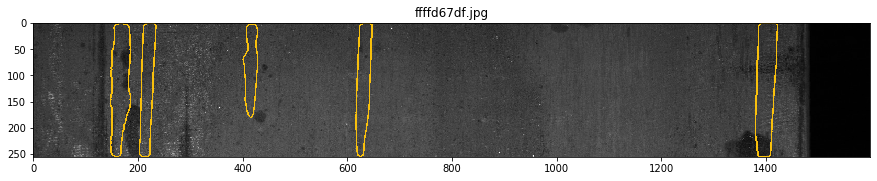

In [132]:
image_name = df["ImageId_ClassId"][26]
label = df.iloc[26:27, 1]
my_show_mask_image(img_name, label)